In [1]:
%matplotlib inline

In [839]:
import ete3
import numpy as np
import random
from Bio import Phylo
from io import StringIO

from matplotlib import pyplot as plt

# For extant species only

This is a modification of the point process representation developed by Tanja Stadler that breaks tree construction into two seperate steps:

1. Get the basic *topology* from random branching
2. *Modify* that topology with the correct branching time (i.i.d.) distributions

In [1669]:
def random_insert(listy, item):
    '''
    I preliminarily tested 2 options for inserting and randomizing new items:
    
    1.
    listy = list(range(1000))
    random_insert(listy, 'a')
    random_insert(listy, 'b')
    
    2.
    listy = list(range(1000))
    listy.extend(['a', 'b'])
    random.shuffle(listy)
    
    Obviously the former doesn't randomize the whole list but I found the implementation using random_insert 
    to be absurdly quicker. As long as the list is grown from an initially randomly shuffled I think that
    this would produce a fully random output. So this function is currently used below.
    
    '''
    listy.insert(random.randrange(len(listy)+1), item)

def get_bd_topology(n_extant_taxa):
    '''
    Docs
    
    Restrictions beta>=mu
    
    
    
    Algorithm notes:
    1. Code is definitely worse than O(n). But don't think that it's quadratic.
    2. Should perhaps test random insertion of the two new children to avoid the 
        re-shuffling step... but are two random insertions worse than one random re-shuffling?
    '''
    my_tree = ete3.Tree() # Instantiate an empty tree
    #Add two leaves to start the first bifurcation
    A = my_tree.add_child(name="", dist=0.) 
    B = my_tree.add_child(name="", dist=0.) 
    #And put those leaves in a list of who to draw from
    all_leaves = [A, B]
    random.shuffle(all_leaves)
    for i in range(n_extant_taxa-2):
        #Choose a random leaf, add two children to it
        choice = all_leaves[-1]
        new_A = choice.add_child(name="", dist=0.)
        new_B = choice.add_child(name="", dist=0.)
        #Remove the leaf and randomly add its children to our running list of extant
        all_leaves = all_leaves[:-1]
        random_insert(all_leaves, new_A)
        random_insert(all_leaves, new_B)
        
    return my_tree

def apply_branch_times_birth_death(my_tree, beta, mu=0.):
    '''
    Docs
    
    As of now the scales don't exactly line up with my expectation from the tedious BD process
    simulation.
    
    Algorithm notes:
    1. Code has the same reshuffle problem as function above which might be able to be written faster
    
    To do:
    1. assert correct inputs
    '''
    n_taxa = len(my_tree.get_leaves())
    input_n = np.random.uniform(size=n_taxa-1)
#     input_n = np.random.uniform(size=n_taxa)

    #Equation modified/directly from Stadler
    # NOTE: I DO HAVE SOME UNCERTAINTY HERE ABOUT WHETHER input_n[0] IS CORRECT
    #       IT IS CURRENTLY JUST ONE OF THE RANDOM UNIFORM NUMBERS WHICH SEEMS WEIRD
    numerator = 1-((mu/beta)*(input_n[0]**(1./n_taxa)))
    denominator = 1-(input_n[0]**(1./n_taxa))
    tree_age = (1./(beta-mu))*np.log(numerator/denominator)
    
    #Equation modified/directly from Stadler
    numerator = beta-(mu*np.exp(-1*(beta-mu)*tree_age))-(mu*(1-np.exp(-1*(beta-mu)*tree_age))*input_n)
    denominator = beta-(mu*np.exp(-1*(beta-mu)*tree_age))-(beta*(1-np.exp(-1*(beta-mu)*tree_age))*input_n)
    branch_times = (1./(beta-mu))*np.log(numerator/denominator)
    branch_times = sorted(branch_times,reverse=True)
#     print(branch_times)
    first = branch_times[0]
    last = branch_times[-1]
    branch_times = first - branch_times
#     print(branch_times)
    branch_times = branch_times + last
#     print(branch_times)
    all_leaves_set = set(my_tree.get_leaves())
    
    #This set subtraction is so that I only assign internal nodes branch times
    #and the options are initially set to the first two nodes coming from the root
    #Would be nice if there was a faster way to get only internal node children via ete3
    options = list(set(my_tree.get_children())-all_leaves_set)
    random.shuffle(options)
#     my_tree.dist = branch_times[0]
    my_tree.dist = 0.
    for btime in branch_times[:-1]:
        choice = options[-1]
        choice.dist = btime - choice.get_distance(my_tree)-my_tree.dist
        options = options[:-1]
        #Again make sure I'm only adding internal nodes to the options
        for child in list(set(choice.get_children())-all_leaves_set):
            random_insert(options, child)
            
    btime = branch_times[-1]
    #Now make the tree ultra-metric by extending the leaves accordingly
    for leaf in my_tree.get_leaves():
        leaf.dist = btime - leaf.get_distance(my_tree) - my_tree.dist
    return my_tree

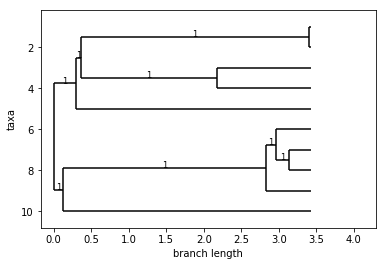

In [1670]:
n_taxa = 10
my_tree = get_bd_topology(n_taxa)
# Phylo.draw(Phylo.read(StringIO(my_tree.write('newick')), 'newick'))
my_tree = apply_branch_times_birth_death(my_tree, 1.0, mu=0.)

Phylo.draw(Phylo.read(StringIO(my_tree.write('newick')), 'newick'))

In [1646]:
print(my_tree.dist, gamma_stat(my_tree))

print([i.dist for i in my_tree.get_leaves()])
print([i.get_distance(my_tree) for i in set(my_tree.get_descendants())-set(my_tree.get_leaves())])

1.0 -2.067289900034543
[0.8182604376171199, 0.6684707715073044, 0.4345941110024696, 0.4345941110024696, 0.007550595130581872, 0.007550595130581872, 0.028527063197782088, 0.361580236734808, 2.384855349527612, 2.384855349527612]
[0.29583951974649847, 1.4035814892964142, 1.7366346628334401, -0.6196936234963897, 1.0966909545239178, 0.9469012884141024, 1.7576111309006404, 1.3305676150287526]


**Testing internal branch length distributions against an exponential**

(array([8., 3., 1., 2., 2., 0., 1., 1., 1., 1.]),
 array([0.19875382, 0.50148408, 0.80421435, 1.10694461, 1.40967487,
        1.71240514, 2.0151354 , 2.31786567, 2.62059593, 2.92332619,
        3.22605646]),
 <a list of 10 Patch objects>)

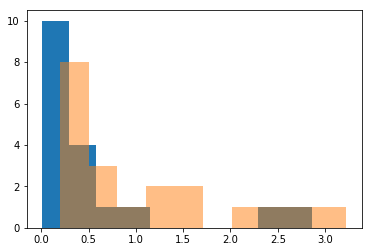

In [963]:
internals = list(set(my_tree.get_descendants())-set(my_tree.get_leaves()))
wtimes = [i.dist for i in internals]
fig, ax = plt.subplots()
ax.hist(wtimes)
ax.hist(np.random.exponential(scale=1.0, size=20), alpha=0.5)

# Birth only model with a traditional method

In [1354]:
def birth_only_tree(birth_rate, target_size=10, max_time=None):
    """
    Original implementaiton from: https://mrnoutahi.com/2017/12/05/How-to-simulate-a-tree/
    """
    done = False
    total_time = 0

    #Initialize
    tree = ete3.Tree()
    tree.dist = 0.0
    #Ensure that a stopping condition is provided
    if not (target_size or max_time):
        raise ValueError('A stopping criterion is required')

    while True:
        #Get the list of extant species
        leaf_nodes = tree.get_leaves()
        #Get desired wait time (exponentially distributed)
        wait_time = np.random.exponential(1/(len(leaf_nodes) * birth_rate))
#         wait_time = np.random.exponential(len(leaf_nodes) * birth_rate)
#         wait_time = random.expovariate(len(leaf_nodes) * birth_rate)
        #Check stopping criteria
        if len(leaf_nodes) >= target_size or (max_time and total_time + wait_time >= max_time):
            done = True
        #Update the length of all current leaves
        max_limited_time = min(wait_time, (max_time or total_time + wait_time) - total_time)
        for leaf in leaf_nodes:
            leaf.dist += max_limited_time
        #Stop there if that was all we needed
        if done:
            break
        #Else, update time
        total_time += max_limited_time
        #Add a new node to a randomly chosen leaf.
        node = np.random.choice(leaf_nodes)
        c1 = ete3.Tree()
        c2 = ete3.Tree()
        node.add_child(c1)
        node.add_child(c2)
        c1.dist = 0.0
        c2.dist = 0.0

    return tree

**Test implementation**

-0.7823471824530401


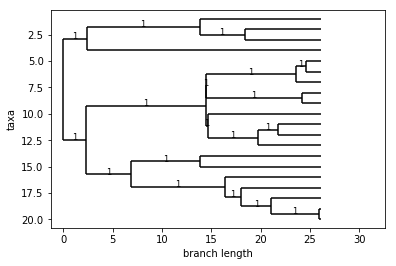

In [1334]:
bo_tree = birth_only_tree(1., 20)
print(gamma_stat(bo_tree))
# tree.render('%%inline', w=500)
Phylo.draw(Phylo.read(StringIO(bo_tree.write('newick')), 'newick'))

**Birth death**

In [1346]:
def delete_single_child_internal(t):
    """Utility function that removes internal nodes
    with a single child from tree"""

    for node in t.traverse("postorder"):
        if(not node.is_leaf() and len(node.get_children()) < 2):
            node.delete()

    if len(t.get_children()) == 1:
        t = t.children[0]
        t.up = None

def birth_death_tree(birth, death, nsize=10, max_time=None, remlosses=True, r=True):
    """
    Generates a birth-death tree.
    Arguments:
        - ``birth`` : birth rate
        - ``death`` : death rate
        - ``nsize`` : desired number of leaves
        - ``max_time`` : maximum time of evolution
        - ``remlosses`` : whether lost leaves (extinct taxa) should be pruned from tree
        - ``r`` : repeat until success
        
    Original implementaiton from: https://mrnoutahi.com/2017/12/05/How-to-simulate-a-tree/
    with modifications (perhaps)

    """
    # initialize tree with root node
    tree = ete3.Tree()
    tree.add_features(extinct=False)
    tree.dist = 0.0
    done = False

    # get current list of leaves
    leaf_nodes = tree.get_leaves()
    curr_num_leaves = len(leaf_nodes)

    total_time = 0
    died = set([])

    # total event rate to compute waiting time
    event_rate = float(birth + death)

    while True:
        # waiting time based on event_rate
        wtime = random.expovariate(event_rate)
        total_time += wtime
        for leaf in leaf_nodes:
            # extinct leaves cannot update their branches length
            if not leaf.extinct:
                leaf.dist += wtime

        if curr_num_leaves >= nsize:
            done = True

        if done:
            break

        # if event occurs within time constraints
        if max_time is None or total_time <= max_time:

            # select node at random, then find chance it died or give birth
            # (speciation)
            node = random.choice(leaf_nodes)
            eprob = random.random()
            leaf_nodes.remove(node)
            curr_num_leaves -= 1

            # birth event (speciation)
            if eprob < birth / event_rate:
                child1 = ete3.Tree()
                child1.dist = 0
                child1.add_features(extinct=False)
                child2 = ete3.Tree()
                child2.dist = 0
                child2.add_features(extinct=False)
                node.add_child(child1)
                node.add_child(child2)
                leaf_nodes.append(child1)
                leaf_nodes.append(child2)
                # update add two new leave
                # (remember that parent was removed)
                curr_num_leaves += 2

            else:
                # death of the chosen node
                if curr_num_leaves > 0:
                    node.extinct = True
                    died.add(node)
                else:
                    if not r:
                        raise ValueError(
                            "All lineage went extinct, please retry")
                    # Restart the simulation because the tree has gone
                    # extinct
                    tree = ete3.Tree()
                    leaf_nodes = tree.get_leaves()
                    tree.add_features(extinct=False)
                    tree.dist = 0.0
                    curr_num_leaves = 1
                    died = set([])
                    total_time = 0

            # this should always hold true
            assert curr_num_leaves == len(leaf_nodes)

    if remlosses:
        # prune lost leaves from tree
        leaves = set(tree.get_leaves()) - died
        tree.prune(leaves)
        # remove all non binary nodes
        delete_single_child_internal(tree)

    leaf_nodes = tree.get_leaves()
    leaf_compteur = 1
    for ind, node in enumerate(leaf_nodes):
        # label only extant leaves
        if not node.extinct:
            # node.dist += wtime
            node.name = "T%d" % leaf_compteur
            leaf_compteur += 1
    return tree

In [1673]:
listy = []
n_taxa = 20
birth_rate = 1.0
for i in range(1000):
    my_tree = get_bd_topology(n_taxa)
    my_tree = apply_branch_times_birth_death(my_tree, birth_rate, mu=0.)
    listy.append(gamma_stat(my_tree))

0.09562165096456703 0.9681791136616057


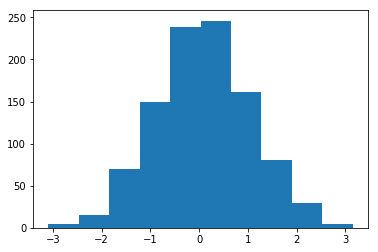

In [1674]:
fig, ax = plt.subplots()
ax.hist(listy)
print(np.mean(listy), np.std(listy))

In [1355]:
n_taxa = 20
birth_rate = 1.0
for i in range(20):
    bo_tree = birth_only_tree(birth_rate, n_taxa)
#     bo_tree = birth_death_tree(birth_rate, 0., n_taxa)
    print(gamma_stat(bo_tree))

0.7509913152203984
-1.1397959393652712
-0.39416520993429033
-0.21723674069142346
0.34785785431257
0.42313163994050845
-0.5955462527150458
-0.4658128578530758
-0.18503282153848571
0.23808358671914204
1.0006737109288002
-0.8911299220897364
-1.1382418413309154
0.24377247375180291
1.2459967562486578
-1.207333034333642
-1.262040487718542
1.1067839567252695
-0.3461864759969165
0.47061508394173246


In [1304]:
from dendropy.simulate import treesim

In [1320]:
t = treesim.birth_death_tree(birth_rate=1.0, death_rate=0., num_extant_tips=20)
t.as_string('newick')

'[&R] ((((T16:0,T3:0):1.7601304371726658,((((T15:0.028146491229868658,T14:0.028146491229868658):0.4190164194673384,T19:0.4471629106972071):0.6835187241402114,T9:1.1306816348374187):0.5247955385004212,T18:1.6554771733378395):0.10465326383482626):0.3018943804453771,((((T13:0.18339601614898443,(T20:0.14998865101637432,T2:0.14998865101637432):0.033407365132610126):0.0264397977583447,T10:0.20983581390732914):0.41957193390156544,(T12:0.005906213616251907,T7:0.005906213616251907):0.6235015341926426):0.31719847675024404,(T5:0.7721521728930357,(T8:0.4016365409074073,T4:0.4016365409074073):0.37051563198562854):0.17445405166610284):1.1154185930589042):0.1909527767315043,(((T17:0.05221913521447388,T1:0.05221913521447388):0.5576158836678834,T11:0.6098350188823572):0.705368029943953,T6:1.3152030488263105):0.9377745455232369):0.5208370337482322;\n'

In [1321]:
ete3_tree = ete3.Tree("((((T16:0,T3:0):1.7601304371726658,((((T15:0.028146491229868658,T14:0.028146491229868658):0.4190164194673384,T19:0.4471629106972071):0.6835187241402114,T9:1.1306816348374187):0.5247955385004212,T18:1.6554771733378395):0.10465326383482626):0.3018943804453771,((((T13:0.18339601614898443,(T20:0.14998865101637432,T2:0.14998865101637432):0.033407365132610126):0.0264397977583447,T10:0.20983581390732914):0.41957193390156544,(T12:0.005906213616251907,T7:0.005906213616251907):0.6235015341926426):0.31719847675024404,(T5:0.7721521728930357,(T8:0.4016365409074073,T4:0.4016365409074073):0.37051563198562854):0.17445405166610284):1.1154185930589042):0.1909527767315043,(((T17:0.05221913521447388,T1:0.05221913521447388):0.5576158836678834,T11:0.6098350188823572):0.705368029943953,T6:1.3152030488263105):0.9377745455232369):0.5208370337482322;")

In [1322]:
gamma_stat(ete3_tree)

0.9119690421839473

In [1324]:
ete3_tree.dist

0.5208370337482322

In [1352]:
random.expovariate(1.)

0.6653715254243493

In [1353]:
np.random.exponential(1.)

0.28933112365099733

In [1621]:
def gamma_stat(tree):
    """
    This was adapted from the APE implementation in R (see: https://rdrr.io/cran/ape/src/R/gammaStat.R)
    
    and tested to make sure it gives equivalent results
    """
    internals = set(tree.get_descendants()) - set(tree.get_leaves())
    n_leaves = len(tree.get_leaves())
    tree_dist = tree.get_leaves()[0].get_distance(tree)+tree.dist
    branching_times = [tree.dist]+[internal.get_distance(tree) for internal in internals]+[tree_dist]
#     tree_dist = tree.get_leaves()[0].get_distance(tree)
#     branching_times = [0]+[internal.get_distance(tree) for internal in internals]+[tree_dist]
    branching_times = sorted(branching_times)
    diffs = np.diff(branching_times)
    tau = np.sum(np.arange(2, n_leaves+1)*diffs)
    denom = tau * np.sqrt(1/(12 * (n_leaves - 2)))
    m = tau/2.
    stat = (1/(n_leaves-2)) * np.sum(diffs[:-1]*np.arange(2, len(diffs)+1)*np.arange(len(diffs)-1, 0, -1))
    gamma_val = (stat-m)/denom

    return gamma_val

In [1771]:
((2**2)-2)//2

1

In [1790]:
n=1000
dicty = {}
dicty[1] = 1
dicty[2] = 1
for tree in range(3, n+1):
    if tree % 2 == 0:
        range_val = tree//2+1
    else:
        range_val = tree//2+1
    tots = []
    for i in range(1, range_val):
        j = tree-i
        if i != j:
            tots.append(dicty[i]*dicty[j])
        else:
            tots.append((((dicty[i]**2)-dicty[i])//2)+dicty[i])
    if tree == 56:
        print(tots)
    dicty[tree] = sum(tots)

[4210157426126929793, 1743130822668362889, 722086038540594854, 598568658655185702, 372345050726881389, 309008961460700622, 235219628752112004, 204336706928265621, 169903556429007946, 150590560688023232, 132429089344259709, 120215259701568218, 109257313409314926, 101071451838787048, 93964802760279000, 88327957101980850, 83487377443480550, 79527549633052677, 76159490852558376, 73374928266996684, 71038138954867133, 69123819323005200, 67563587823166531, 66334897047706189, 65402209700277926, 64751109615727062, 64364558146013683, 32118631579928116]


In [1796]:
dicty[50]

51501493576783437